In [2]:
# just here
%load_ext autoreload
%autoreload 2

In [3]:
# imports
import pandas as pd
import pynapple as nap
import matplotlib.pyplot as plt
import iblphotometry.loaders as loaders
import iblphotometry.plots as plots

In [3]:
# ONE instantiation
from one.api import ONE
one = ONE(base_url="https://alyx.internationalbrainlab.org", mode='remote')

In [ ]:
# load data via data_loader
eids = one.search(dataset='photometry.signal.pqt', lab='wittenlab')
eid = eids[2]

data_loader = loaders.PhotometryLoader(one)
raw_photometry = data_loader.load_photometry_data(eid, signal='GCaMP')
trials = data_loader.load_trials_table(eid)

In [ ]:
from iblphotometry.outlier_detection import remove_spikes
from iblphotometry.bleach_corrections import lowpass_bleachcorrect
from iblphotometry.sliding_operations import sliding_mad
from iblphotometry.pipelines import run_pipeline

pipeline = [
      (remove_spikes, dict(sd=5)),
      (lowpass_bleachcorrect, dict(correction_method='subtract-divide',
                                   filter_params=dict(N=3, Wn=0.01, btype='lowpass'))),
      (sliding_mad, dict(w_len=120,overlap=90)),
]

# run pipeline
photometry = run_pipeline(raw_photometry, pipeline, on_columns=True)
data_loader.get_mappable(eid)
# photometry


In [ ]:
# view a short snippet
interval = nap.IntervalSet(start=10, end=20)
plots.plot_TsdFrame(photometry.restrict(interval))

In [ ]:
# plot psths
region = 'Region0G'
plots.plot_psth(photometry[region], trials, event='feedback_times', split_by='choice')

In [4]:
# KCENIA / isosbestic specific
from one.api import ONE
one = ONE(cache_dir='/mnt/h0/kb/data/one')
data_loader = loaders.KceniaLoader(one)
df = pd.read_csv('/home/georg/code/ibl-photometry/src/local/website.csv')
eids = list(df['eid'])[:20]  # <- debug

(<Figure size 1400x800 with 4 Axes>,
 {'top': <Axes: label='top', title={'center': 'photometry signal'}, xlabel='time (s)', ylabel='photometry trace'>,
  'left': <Axes: label='left', xlabel='Frequency', ylabel='Power Spectral Density (dB/Hz)'>,
  'right': <Axes: label='right', title={'center': 'Cross-plot'}, xlabel='isosbestic signal', ylabel='calcium dependent signal'>})

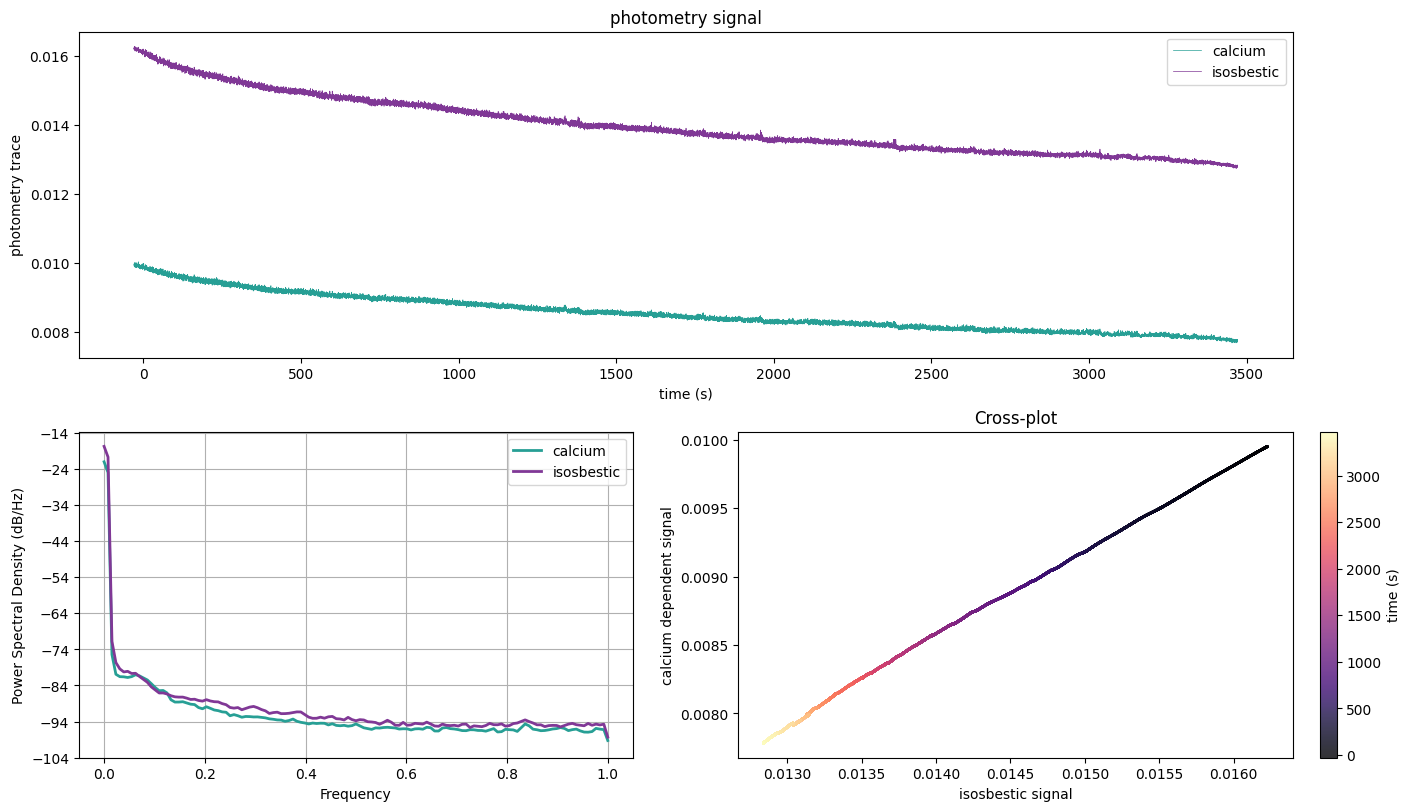

In [5]:
pid, pname = data_loader.eid2pid(eids[14])
raw_photometry = data_loader.load_photometry_data(pid=pid[0])
plots.plot_isosbestic_overview(raw_photometry['raw_calcium'], raw_photometry['raw_isosbestic'])

/home/georg/code/ibl-photometry/src/iblphotometry/pipelines.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  d_[:, i] = pipe_func(Fc[col], **pipe_args)
/home/georg/code/ibl-photometry/src/iblphotometry/pipelines.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  d_[:, i] = pipe_func(Fc[col], **pipe_args)


<Axes: xlabel='time (s)', ylabel='signal (au)'>

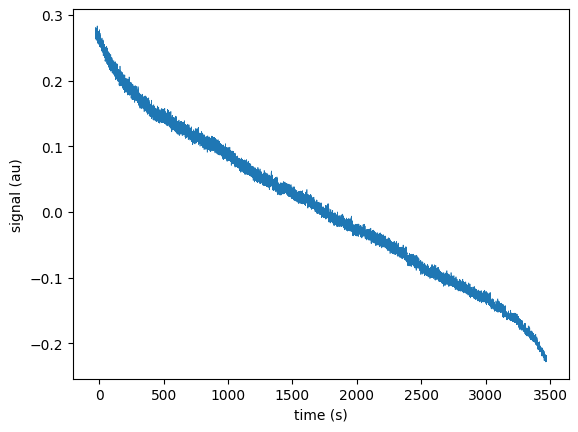

In [15]:
from iblphotometry.outlier_detection import remove_spikes
from iblphotometry.bleach_corrections import lowpass_bleachcorrect
from iblphotometry.bleach_corrections import isosbestic_correct
from iblphotometry.sliding_operations import sliding_mad
from iblphotometry.pipelines import run_pipeline

pipeline = [
      (remove_spikes, dict(sd=5)),
      # (lowpass_bleachcorrect, dict(filter_params=dict(N=3, Wn=0.01, btype='lowpass'))),
      (isosbestic_correct, dict(on_columns=False,
                                signal_name='raw_calcium',
                                reference_name='raw_isosbestic',
                                correction_method='subtract-divide',
                              #   regression_method='huber',
                                lowpass_isosbestic=dict(N=3, Wn=0.01, btype='lowpass')),),
      # (sliding_mad, dict(w_len=120,overlap=90)),

]

# run pipeline
photometry = run_pipeline(raw_photometry, pipeline)
plots.plot_Tsd(photometry)

In [ ]:
# from iblphotometry.bleach_corrections import IsosbesticCorrection
# iso = IsosbesticCorrection()
# tsd = iso.correct(raw_photometry['raw_isosbestic'], raw_photometry['raw_calcium'])
raw_photometry = data_loader.load_photometry_data(pid=pid[0])
# plt.plot(raw_photometry['raw_isosbestic'])
raw_photometry = data_loader.load_photometry_data(pid=pid[0])
plt.plot(raw_photometry['raw_isosbestic'].d, raw_photometry['raw_calcium'].d,'.')